# Figure - misleading errors

In [1]:
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ptyrad.load import load_hdf5, load_pt
from ptyrad.utils.image_proc import center_crop
import h5py

In [3]:
def get_error_from_str(string):
    import re
    # Regular expression to find the number after "_error_"
    match = re.search(r'_error_([\d.eE+-]+)', string)

    if match:
        return f"{float(match.group(1)):.5f}"  # Ensures 5 decimal places
    else:
        print("No match found")

## Developing new metrics

In [4]:
def get_total_variation(img):
    """Calculates the total variation of a 2D image."""

    # Compute the horizontal and vertical differences
    diff_x = np.diff(img, axis=1)
    diff_y = np.diff(img, axis=0)

    # Calculate the total variation
    tv = np.sum(np.abs(diff_x)) + np.sum(np.abs(diff_y))

    return tv / img.size
    
def get_std(img):
    return np.std(img)

def get_contrast(img):
    return np.std(img) / np.mean(img)

def get_power_sum(img):
    power = np.abs(np.log(np.abs(np.fft.fft2(img))))
    return power.sum()**2

def get_power_sum_std(img):
    power = np.abs(np.log(np.abs(np.fft.fft2(img))))
    return power.sum()**2 * power.std()

## Double error metrics

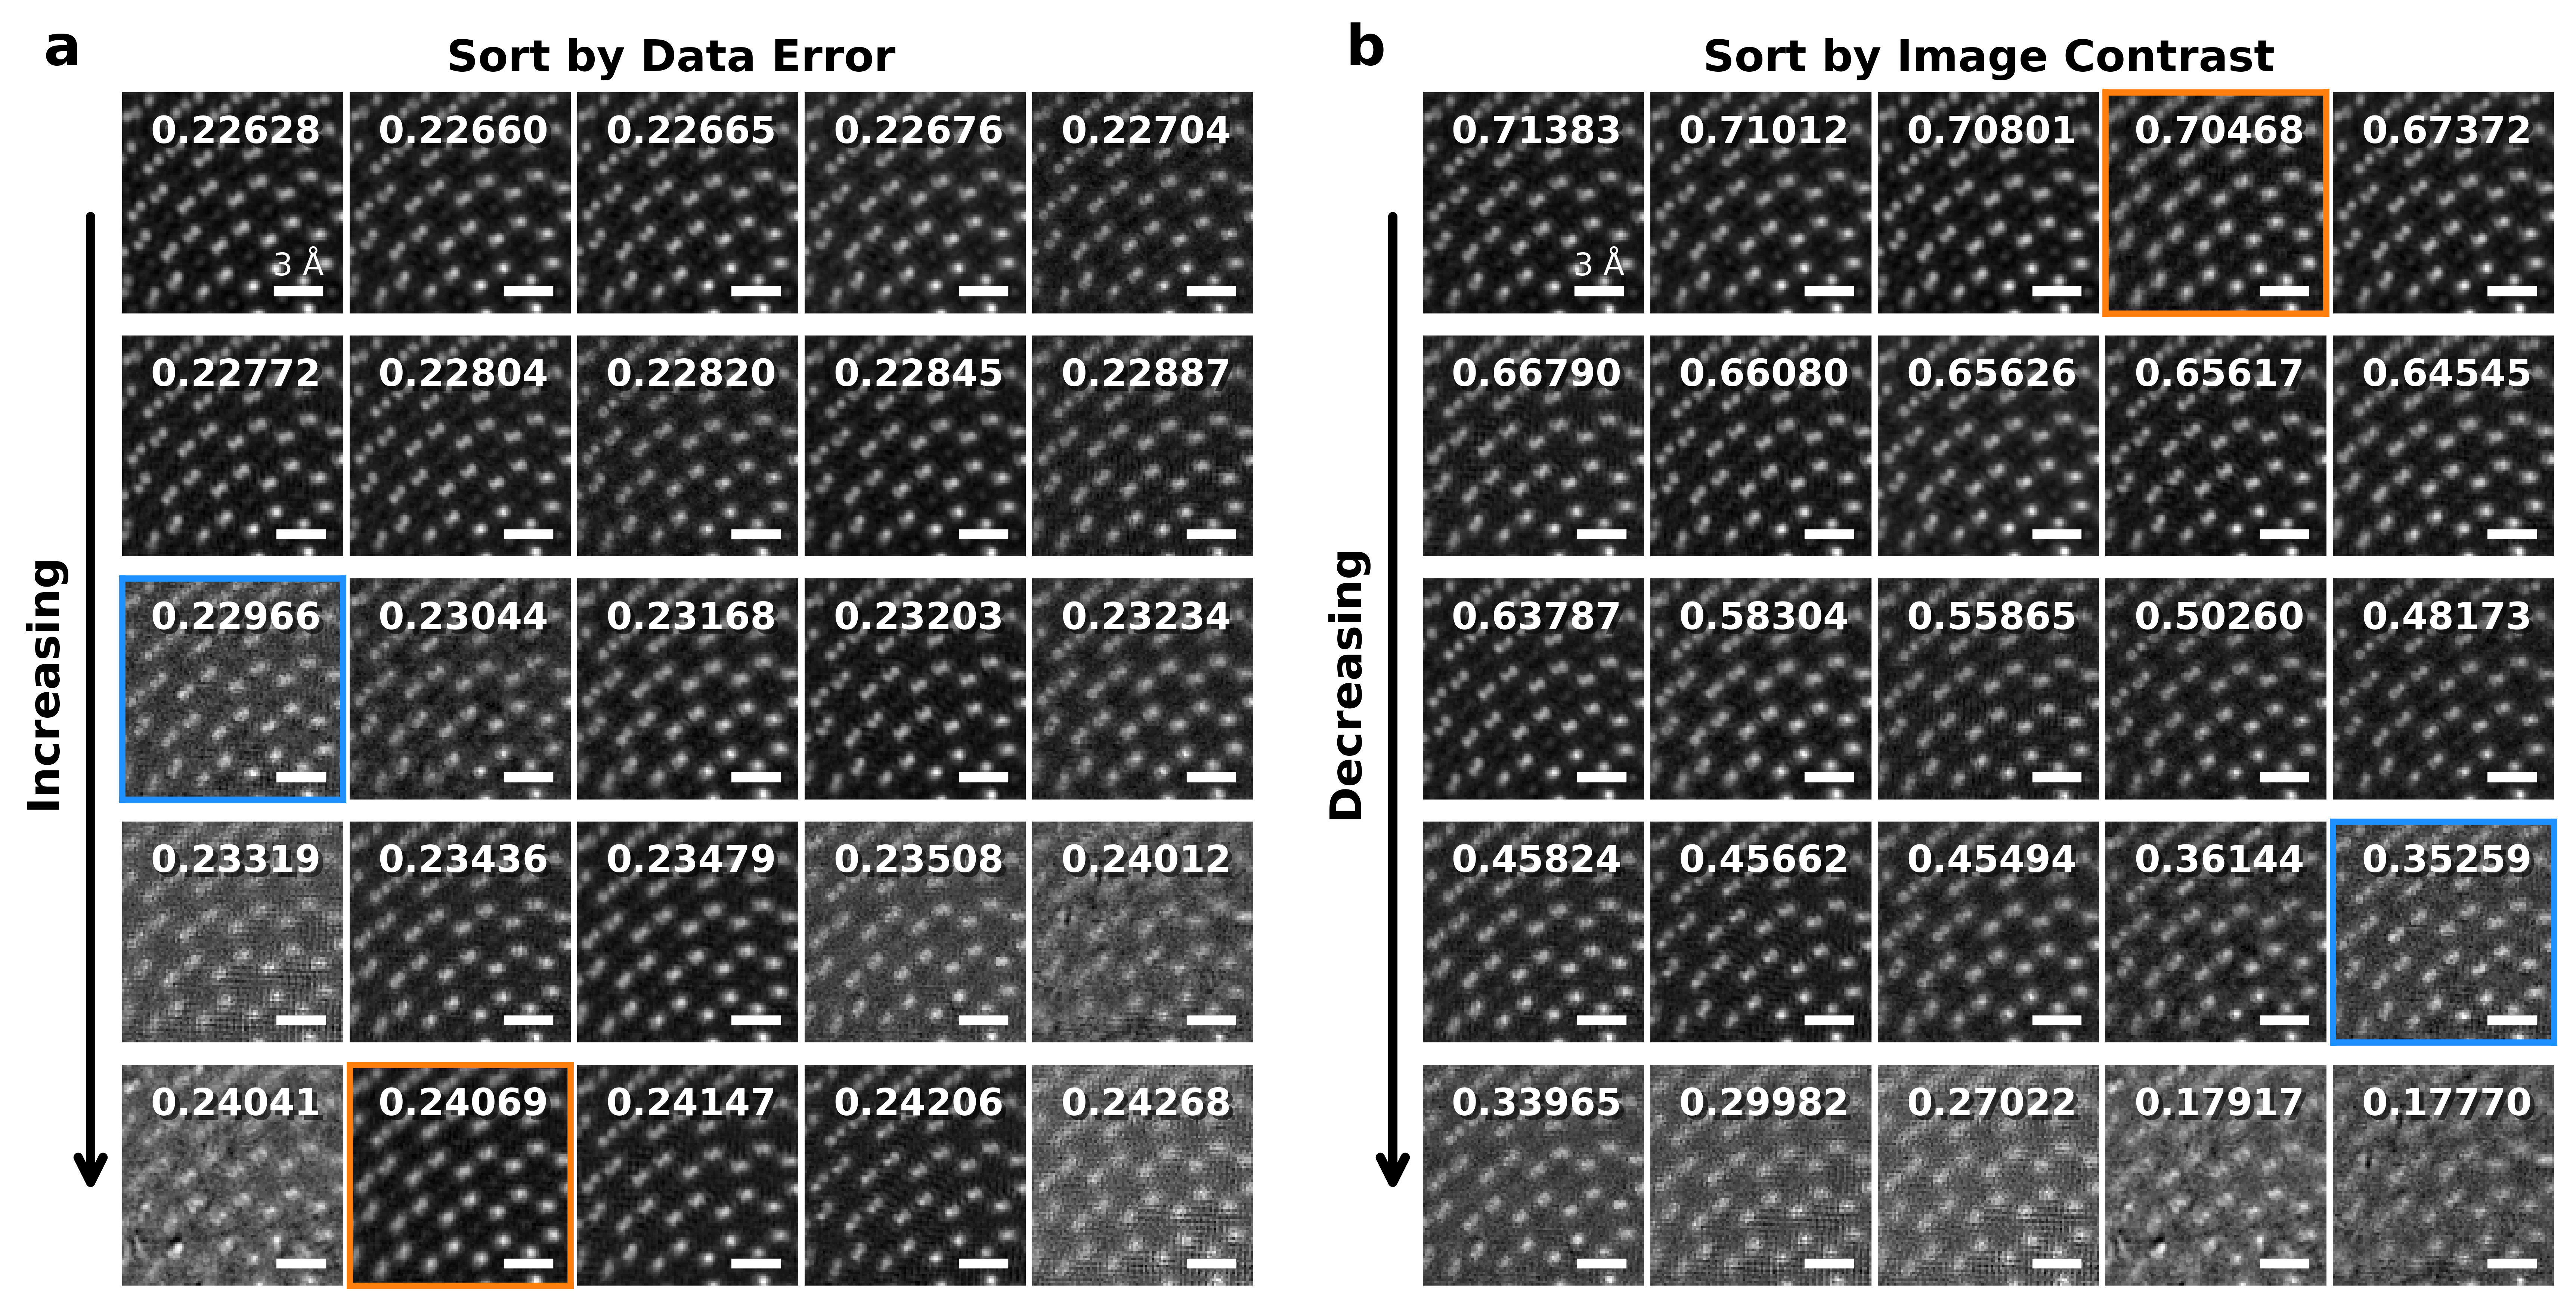

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tifffile import imread

# Set output directory and grid size
output_dir = '03_output/tBL_WSe2/20250125_hypertune_GridSampler_convergence_optimization'

rows, cols = 5, 5  # Specify number of rows and columns for each grid

# Load, sort by data error, and select files for the panes
all_files = os.listdir(output_dir)
file_names = [file for file in all_files if file.startswith('objp_zsum_crop_08bit_error_0.2')]
file_names.sort()
k = 3  # Select every k-th image
file_names_select = file_names[::k][:rows*cols]

# Load images, crop, retrieve errors
imgs = []
errors = []
contrasts = []
for i, file_name in enumerate(file_names_select):
    img_path = os.path.join(output_dir, file_name)
    img = center_crop(imread(img_path), 96, 96)
    error = get_error_from_str(file_name)

    imgs.append(img)
    errors.append(float(error))
    contrasts.append(get_contrast(img))
    
# Create another array that sorts by contrast
contrast_sort_idx = np.argsort(contrasts)[::-1]
imgs_contrast = np.array(imgs)[contrast_sort_idx]
errors_contrast = np.array(contrasts)[contrast_sort_idx]

# Set the offset of text/labels
shadow_offset = [2, 2]
text_offset = [12, 9]

# Panel indices for colored edges
box_idx0 = 10
box_idx1 = 21

# Scale bar settings
scale_bar_length = 20.08  # Length of the scale bar in pixels (1 px = 0.1494 Ang)
scale_bar_label = "3 $\\mathrm{\\AA}$"
scale_bar_color = "white"
fontprops = fm.FontProperties(size=10)

# Create figure with an outer 2-column grid
fig = plt.figure(figsize=(14, 7), dpi=600)
outer_grid = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.15)

# Create two nested grids inside the outer grid
left_grid = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=outer_grid[0], wspace=0.03, hspace=0.03)
right_grid = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=outer_grid[1], wspace=0.03, hspace=0.03)

# Combine axes lists for convenience
axs0 = [fig.add_subplot(left_grid[i, j]) for i in range(rows) for j in range(cols)]
axs1 = [fig.add_subplot(right_grid[i, j]) for i in range(rows) for j in range(cols)]

# Plot images in two separate grids
for i, axs in enumerate([axs0, axs1]):
    for j in range(len(file_names_select)):
        if i == 1:
            imgs_plot = imgs_contrast
            errors_plot = errors_contrast
        else:
            imgs_plot = imgs
            errors_plot = errors
            
        # Plot the left/right grid
        axs[j].imshow(imgs_plot[j], cmap='gray')
        axs[j].axis('off')

        if i ==0:
            # Add blue edge to box_idx0
            axs[box_idx0].axis('on')
            axs[box_idx1].axis('on')
            axs[box_idx0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            axs[box_idx1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            for spine in axs[box_idx0].spines.values():
                spine.set_edgecolor('dodgerblue')
                spine.set_linewidth(2)

            # Add orange edge to box_idx1
            for spine in axs[box_idx1].spines.values():
                spine.set_edgecolor('C1')
                spine.set_linewidth(2)
        else:
            # Add the boxes to the corresponding position when they're sorted by contrast
            box_idx0_contrast = np.where(contrast_sort_idx == box_idx0)[0].item()
            box_idx1_contrast = np.where(contrast_sort_idx == box_idx1)[0].item()
            # Add blue edge to box_idx0
            axs[box_idx0_contrast].axis('on')
            axs[box_idx1_contrast].axis('on')
            axs[box_idx0_contrast].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            axs[box_idx1_contrast].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            for spine in axs[box_idx0_contrast].spines.values():
                spine.set_edgecolor('dodgerblue')
                spine.set_linewidth(2)

            # Add orange edge to box_idx1
            for spine in axs[box_idx1_contrast].spines.values():
                spine.set_edgecolor('C1')
                spine.set_linewidth(2)

        # Add label with text shadow
        error = f"{errors_plot[j]:.5f}"
        axs[j].text(
            text_offset[0] + shadow_offset[0], text_offset[1] + shadow_offset[1], error,
            color='black', fontsize=12, fontweight='bold', va='top', ha='left', alpha=0.6
        )
        axs[j].text(
            text_offset[0], text_offset[1], error, color='white', fontsize=12, fontweight='bold', va='top', ha='left'
        )

        # Add scale bar
        scalebar_label = scale_bar_label if j == 0 else ''
        scalebar = AnchoredSizeBar(axs[j].transData, scale_bar_length, scalebar_label,
                                loc='lower right', pad=0.5, color=scale_bar_color, frameon=False,
                                size_vertical=3, label_top=True, fontproperties=fontprops)
        axs[j].add_artist(scalebar)
        
# Add text labels 'a' and 'b' outside grids
fig.text(0.10, 0.92, 'a', fontsize=18, fontweight='bold', ha='left', va='top')  # Label for left grid
fig.text(0.515, 0.92, 'b', fontsize=18, fontweight='bold', ha='left', va='top')  # Label for right grid

# Add text labels 'Increasing' and 'Decreasing' outside grids
fig.text(0.10, 0.50, 'Increasing', fontsize=14, fontweight='bold', ha='center', va='center', rotation=90)  # Label for left grid
fig.text(0.515, 0.50, 'Decreasing', fontsize=14, fontweight='bold', ha='center', va='center', rotation=90)  # Label for right grid

# Add text labels 'Data Error' and 'Image Contrast' outside grids
fig.text(0.30, 0.91, 'Sort by Data Error', fontsize=14, fontweight='bold', ha='center', va='top')  # Label for left grid
fig.text(0.72, 0.91, 'Sort by Image Contrast', fontsize=14, fontweight='bold', ha='center', va='top')  # Label for right grid

# Left arrow (from top to bottom)
arrow_left = patches.FancyArrowPatch((0.115, 0.8), (0.115, 0.17), transform=fig.transFigure,
                                    arrowstyle="->", lw=3, color="black", mutation_scale=20)
fig.patches.append(arrow_left)

# Right arrow (from top to bottom)
arrow_right = patches.FancyArrowPatch((0.53, 0.8), (0.53, 0.17), transform=fig.transFigure,
                                    arrowstyle="->", lw=3, color="black", mutation_scale=20)
fig.patches.append(arrow_right)

plt.savefig("05_figures/Fig_S13_misleading_error.pdf", bbox_inches="tight")
plt.savefig("05_figures/Fig_S13_misleading_error.png", bbox_inches="tight")

plt.show()
